Code for google colab

In [31]:
#@title Parameters choice

#@markdown ##### Is a GPU available (mostt likely to be an option if working on Google colab):
GPU = True    #@param {type:"boolean"}
#@markdown ##### If indeed running this code on Google colab:
Google_colab = True #@param {type:"boolean"}
#@markdown ---
#@markdown ### Enter an image file path:
Image_Directory = "/content/gdrive/MyDrive/ML_2_transcripted_cherry/test/" #@param {type:"string"}
#@markdown ---
#@markdown ### Enter a mask file path:
Image_Directory_mask = "/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/" #@param {type:"string"}
Use_masks_computed = False    #@param {type:"boolean"}
#@markdown ---
#@markdown ### Enter a feature (output) file path:
feature_directory = "/content/gdrive/MyDrive/ML_2_transcripted_cherry/Features/" #@param {type:"string"}
#@markdown ##### One still needs to adapat the last chuncks to give a coherent file name with regard to what has been computed (which TF's)
#@markdown ### Save parameter
Save = True    #@param {type:"boolean"}

In [32]:
if(Google_colab):
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

  from psutil import virtual_memory
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')

  !pip install cellpose  
  !pip install scikit-image==0.19.3

  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)

Thu Dec 22 09:30:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |   2914MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
# Import modules
import numpy as np
import pandas as pd
import time, os, sys, random
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import models, plot
from cellpose.io import imread
import skimage.io
from skimage.util import img_as_ubyte
from skimage.measure import label, regionprops
from skimage import measure
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb
from skimage.transform import rotate
from skimage.morphology import square, dilation
import scipy
from scipy import ndimage as ndi
import cv2
from sklearn.cluster import KMeans
# https://stackoverflow.com/questions/19970764/making-feature-vector-from-gabor-filters-for-classification
# https://stackoverflow.com/questions/20608458/gabor-feature-extraction

# Read image

In [40]:
#- Read image folders-----------------------------------------------------
# Get path to folders containing images
'''
folder_name = input('Folder name:')
Image_Directory = os.getcwd() + folder_name'''
#Image_Directory = "/content/gdrive/MyDrive/ML_2_transcripted_cherry/TF1/"

# Create Lists containing datapath to all images of Cherry/ Ypet files
image_format = "tif"
cherry_condition = "TexasRed"
ypet_condition = "YFP"
Cherry_file = []
Ypet_file = []
TF_name_tot = []
img_num_tot = []

print('Input 1 if you want to read all images within the folder (set by validating with <enter>).') 
print('Input 2 if you want to read a specific TF.')
print('If the number of pictures within a folder is too big for the computer to compute at once, number 2 is adviced')
read_all = input()

if read_all == '2':
    if (read_all == '2'):
        print('')
        TF_letter = input('The letter of the TF name (e.g. A for A - 1):') + '     '
        print('')
        print('The number of the TF name (e.g. 1 for A - 1)')
        TF_number_check = input('If you want to read all TF for one letter (from 1 to 12), enter 100:')
        if int(TF_number_check) < 100:
            TF_number = np.array(int(TF_number_check))
        else: 
            TF_number = np.arange(0,13,1)

# Walk through directory (call all files) and assign them to proper list
for root, dirs, files in os.walk(Image_Directory, topdown=False): # root = given in Input, dirs = folders, files= files
    for f in files:
        
        if read_all == '2': # Check which TF we want to read according to input above
            letter_test = f.partition("(")[0].partition('-')[0]
            if letter_test not in TF_letter: 
                continue # goes to next loop
            number_test = int(f.partition("(")[0].partition('-')[2])
            if number_test not in TF_number:
                continue  
                
        if f.endswith(image_format) and cherry_condition in f: 
            f_part = f.partition("(")
            TF_name_tot.append(f_part[0])
            img = ""
            for c in f_part[2]:
                if(c.isdigit()):
                    img = img + c
            img = int(img)
            img_num_tot.append(img)
            Cherry_file.append(os.path.join(root, f))
        elif f.endswith(image_format) and ypet_condition in f: 
            Ypet_file.append(os.path.join(root, f))


Input 1 if you want to read all images within the folder (set by validating with <enter>).
Input 2 if you want to read a specific TF.
If the number of pictures within a folder is too big for the computer to compute at once, number 2 is adviced
2

The letter of the TF name (e.g. A for A - 1):B

The number of the TF name (e.g. 1 for A - 1)
If you want to read all TF for one letter (from 1 to 12), enter 100:2


In [41]:
print(Cherry_file)
print(img_num_tot)
print(TF_name_tot)

['/content/gdrive/MyDrive/ML_2_transcripted_cherry/test/B - 2(fld 6 wv TexasRed - TexasRed).tif', '/content/gdrive/MyDrive/ML_2_transcripted_cherry/test/B - 2(fld 7 wv TexasRed - TexasRed).tif']
[6, 7]


In [42]:
# Number of images we want to read. 
nb_images = len(TF_name_tot)

# Initialize lists containing cherry, ypet images. Length = nb_images or len(Cherry_file) if we want to read all images
cherry_imgs = np.ndarray(nb_images,dtype = np.ndarray)
ypet_imgs = np.ndarray(nb_images,dtype = np.ndarray)
 
# Read image file (We donnot add it in for loop above to enable reading subset of image)
for i in range(nb_images):
    cherry_imgs[i] = imread(Cherry_file[i])
    ypet_imgs[i] = imread(Ypet_file[i])  #Sometimes(always?) this line crash the first time and then work..?
    
cherry_imgs = cherry_imgs.tolist()
ypet_imgs = ypet_imgs.tolist()

## Read mask if it has already been implemented

In [43]:
if (Use_masks_computed):
  #Image_Directory_mask = "/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/"
  mask_directionary = []
  for root, dirs, files in os.walk(Image_Directory_mask, topdown=False): # root = given in Input, dirs = folders, files= files
      for f in files:
            mask_directionary.append(os.path.join(root, f))  #Warning: .append often slow
  print(mask_directionary)
  sort_ind = [7,2,4,9,8,6,5,10,3,11,12,1]
  mask_directionary_sorted = [mask_directionary for _, mask_directionary in sorted(zip(sort_ind, mask_directionary))]
  print('-------------------------------')
  mask_directionary_sorted
  masks = []
  for i in range(nb_images):
    masks.append(imread(mask_directionary_sorted[i]))
    plt.imshow(masks[0])

## Image segmentation

In [44]:
# Definine parameters for cellpose module using nuclei modus
# https://cellpose.readthedocs.io/en/latest/settings.html
channels = [0,0] # Corresponds to greyscale image
diameter = None # Model was trained on diameters of 17 pixels. None-> automated estimation of the diameter. Can be changed by hand later
flow_threshold = 0.4 # maximum allowed error of the flows for each mask, default = 0.4
gpu = GPU
model_type='nuclei'

# Set model
model = models.Cellpose(gpu, model_type)

# Nuclei segmentation of all images within cherry_imgs list
masks, flows, styles, diams = model.eval(cherry_imgs, diameter=diameter, channels=channels, flow_threshold=flow_threshold, do_3D=False)


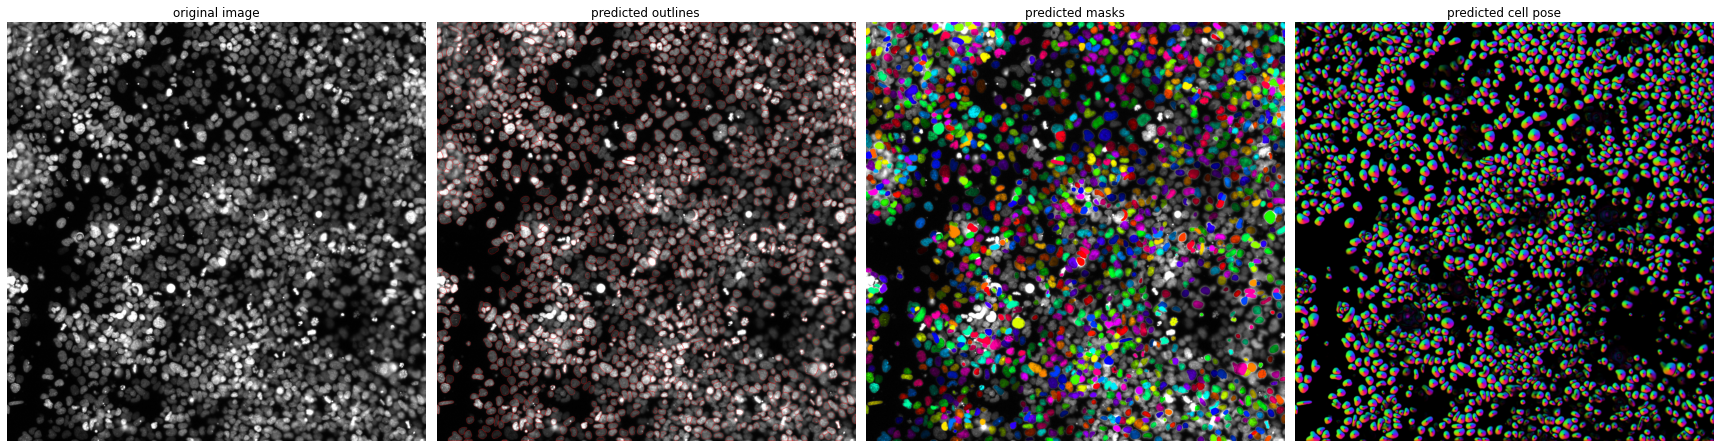

In [45]:
# Display results
image_i = 1 # Number of image we want to display. Max value= nb_images or len(Cherry_file)
fig = plt.figure(figsize=(24,8))
plot.show_segmentation(fig, cherry_imgs[image_i], masks[image_i], flows[image_i][0], channels)
plt.tight_layout()
plt.show()

***
## Feature extraction

In [46]:
def gabor_feature_extraction(kernels,patch_data):
    # Apply Gabor filter: We receive per kernel a response. We stack all the response to one matrix---------------------------------------------------------
    image = patch_data
    g_response = []

    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        g_response.append(filtered)
    n_clusters = len(g_response)
    g_response = np.vstack(g_response)

    # Cluster Gabor response with k-means. Find which part of the pixel belongs to which Gabor response ---------------------------------------------------------
    random_state = 1
    random.seed(random_state)
    kmean = KMeans(n_clusters, random_state=random_state).fit(g_response) #

    # Texton map: Assign each pixel to the identity of the closest cluster center---------------------------------------------------------
    histogram = np.histogram(kmean.labels_, bins = len(np.unique(kmean.labels_)))
    # Normalize
    gabor_feature = histogram[0] / histogram[0].sum()
    return gabor_feature

In [47]:
def feature_binary_pattern(patch_data):
    # Apply lbp
    METHOD = 'uniform' #  'default'
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(patch_data, n_points, radius, METHOD)
    
    # Create histogram
    count = len(np.unique(lbp))
    H, bins = np.histogram(lbp, count)

    # Drop background values
    w = width = radius - 1
    index_background = n_points - w
    H = H[0: index_background]
    bins =  bins[0: index_background]

    # plt.bar(bins,H,width=1)
    
    # Normalize
    lbp_feature = H / H.sum()
    return lbp_feature

In [48]:
def similarity_computation(cherry_data, variance_data):
    cherry_compare = cherry_data
    cherry_compare = cherry_compare/cherry_compare.max()
    cherry_compare = np.where(cherry_compare>cherry_compare.min()*1.7,1,0)
    cherry_compare = pd.DataFrame(cherry_compare)

    patch_compare = variance_data
    patch_compare = patch_compare/patch_compare.max()
    patch_compare = np.where(patch_compare>patch_compare.min()*1.7,1,0)
    patch_compare = np.where(patch_compare>0,1,0)
    patch_compare = pd.DataFrame(patch_compare)

    boolean_test = patch_compare == cherry_compare
    boolean_value = boolean_test.sum().sum()
    total_img = cherry_compare.shape[0] * cherry_compare.shape[1]
    similarity = round(boolean_value / total_img,3)
    return similarity

In [50]:
# prepare Gabor filter bank kernels---------------------------------------------------------
kernels = []
sigmas = [1,3]
tilts = [0,0.25,0.5,0.75] # perpendicular, diagonal, horizontal, other diagonal 
Wavelengths = [0.25,0.75] 
gamma =  0.5 # Spatial aspect ratio
psi = 0 # Phase offset.

for tilt in tilts:
    for sigma in sigmas:
        for lambd in Wavelengths:
            kernel = cv2.getGaborKernel((10,10), sigma, tilt, lambd, gamma, psi, ktype = cv2.CV_32F)
            kernels.append(kernel)

In [57]:
# Extract feature of each nucleus within images nb_images
ypet_intensity_tot = []
for j in range(nb_images): #nb_images
    
    # Initialize features: Faster then appending values to list with append
    mask =  masks[j]  
    TF_name = TF_name_tot[j]
    imgs = img_num_tot[j]
    start_nucleus = 1 # we have to at least start from 1, otherwise we take whole mask
    end_nucleus =  len(np.unique(mask)) #len(np.unique(mask)) # len(np.unique(mask))  #IMAGE SPECIFIC: cases where cell are big enough (sell last cell of the notebook)
    range_s = range(start_nucleus, end_nucleus)
    ypet = ypet_imgs[j]
    columnname = ["" for i in range_s]
    blur = [False for i in range_s]
    patch_size = [0 for i in range_s]
    mean_intensity = [0 for i in range_s]
    sum_intensity = [0 for i in range_s]
    median_intensity = [0 for i in range_s]
    std_intensity = [0 for i in range_s]
    var_intensity = [0 for i in range_s]
    skew_intesity = [0 for i in range_s]
    kurt_intesity = [0 for i in range_s]
    iqr_intesity = [0 for i in range_s]
    entropy_intesity = [0 for i in range_s]
    gabor_features = [0 for i in range_s]
    lbp_features = [0 for i in range_s]
    blur_lapl = [False for i in range_s]
    blur_ski = [False for i in range_s]
    similarity = [False for i in range_s]    
    hull_area = [0 for i in range_s]      
    correlation_coef = [0 for i in range_s]  
    #calculate different properties of the mask
    props = regionprops(mask)
    
    #initialize arrays to store information from the mask
    perimeter = [0 for i in range_s]
    feret_diameter_max = [0 for i in range_s]
    axis_major = [0 for i in range_s]
    axis_minor = [0 for i in range_s]
    solidity = [0 for i in range_s]
    
    # Iterate through all nucleus: Take submatrix, Calculate patch size and corresponding ypet signal (mean) and store it into ypet_intensity
    iter_i = 0 # Ensures that no 0 are saved where patch is too small/big
    
    for i in range_s:# # Iterate through all nucleus: in range(start_nucleus, end_nucleus)
        cur = ypet[mask==i]
        patch_size_ = np.count_nonzero(~np.isnan(cur))
        
        # Extract subimage ----------------------------------------------------------------
        # Extract subimage of nucleus (Not just its values, which is done above)
        boolean = np.where(mask==i, 1,False) # Boolean matrix where patch = 1, else 0
        patch_values = ypet*boolean
        # Extract submatrix with a buffer of 3 pixels to calculate the blurrness
        variance_boolean = dilation(boolean, square(7))
        variance_values = ypet * variance_boolean
        
        # Drop pixels without nucleus information ----------------------------------------------------------------
        # Initialize conditions on when a column/ row should be dropped
        drop_nucleus = False
        drop_column = []
        drop_column_variance = []
        drop_row = []
        drop_row_variance = []
        
        
        # Iterate through all columns to find nucleus that is on the border and the columns that only contain mask
        for column in range(boolean.shape[1]):
            
            # drop nucleus if it's on the border 
            if (((column == 0) | (column == boolean.shape[1]-1)) & (np.any(boolean[:,column])== True)):
                drop_nucleus = True
                break 
                
            # drop if column has no information about nucleus: first check for broader variance_submatrix (Matrix with a buffer around submatrix to calculate variance). Then smaller submatrix 
            if np.any(variance_boolean[:,column])== False:
                drop_column_variance.append(column) 
                drop_column.append(column) 
            elif np.any(boolean[:,column])== False: 
                drop_column.append(column) 
        
        # Iterate through all columns to find nucleus that is on the border and the columns that only contain mask
        for row in range(boolean.shape[0]):
            
            # drop nucleus if it's on the border 
            if (((row == 0) | (row == boolean.shape[0]-1)) & (np.any(boolean[row,:])== True)):
                drop_nucleus = True
                break
                
            # drop if row has no information about nucleus:  first check for broader variance_submatrix  
            if np.any(variance_boolean[row,:])== False:
                drop_row.append(row)
                drop_row_variance.append(row)
            elif np.any(boolean[row,:])== False: 
                drop_row.append(row)
        
        # Drop pixels without nucleus information
        patch_data = np.delete(patch_values,drop_column,1)  
        patch_data = np.delete(patch_data,drop_row,0) 
        
        variance_data = np.delete(ypet,drop_column_variance,1)  
        variance_data = np.delete(variance_data,drop_row_variance,0) 
        cherry_data = np.delete(cherry_imgs[j], drop_column_variance,1)
        cherry_data = np.delete(cherry_data,drop_row_variance,0) 
        
        
        
        # Feature calculation ----------------------------------------------------------------
        
        if ((patch_size_ > 10) & (patch_size_ < 50000) & (drop_nucleus== False)): 
            gabor_features_current = gabor_feature_extraction(kernels,patch_data) # List of two arrays, first nb of counts in histogram, second: bin number
            if len(gabor_features_current) < len(kernels): continue 
            else: gabor_features[iter_i] = gabor_features_current

            temp_lbp = feature_binary_pattern(patch_data)
            if len(temp_lbp) < 8: continue
            else: 
              lbp_features[iter_i]  = temp_lbp
              lbp_count = len(temp_lbp)
           
            # extract intensity feature
            columnname[iter_i] = "patch_" + str(i)    #We should not forgot that there is a -1 here. (when it is here)               
            patch_size[iter_i] = patch_size_
            blur_lapl[iter_i] = cv2.Laplacian(variance_data, cv2.CV_64F).var()
            blur_ski[iter_i] = measure.blur_effect(variance_data)
            sum_intensity[iter_i] = np.sum(np.sum(cur))
            mean_intensity[iter_i] = np.nanmean(cur)
            median_intensity[iter_i] = np.nanmedian(cur)
            
            std_intensity[iter_i] = np.nanstd(cur)
            var_intensity[iter_i] = np.nanvar(cur)
            skew_intesity[iter_i] = scipy.stats.skew(cur)
            kurt_intesity[iter_i] = scipy.stats.kurtosis(cur)
            iqr_intesity[iter_i] = scipy.stats.iqr(cur)
            entropy_intesity[iter_i] = scipy.stats.entropy(cur)
            perimeter[iter_i] = props[i-1].perimeter
            feret_diameter_max[iter_i] = props[i-1].feret_diameter_max
            axis_major[iter_i] = props[i-1].major_axis_length
            axis_minor[iter_i] = props[i-1].minor_axis_length
            solidity[iter_i] = props[i-1].solidity
            hull_area[iter_i] = props[i-1].area_convex
            similarity[iter_i] = similarity_computation(cherry_data, variance_data)
            dna = cherry_data.flatten()
            expression = variance_data.flatten()
            correlation_coef[iter_i] = round(np.corrcoef(dna,expression)[0,1],5)

            
            iter_i +=1
    
       
    ypet_intensity = pd.DataFrame()
    ypet_intensity['patch'] = columnname
    ypet_intensity['img'] = imgs
    ypet_intensity['TF_name'] = TF_name
    ypet_intensity['blur_lapl'] = blur_lapl
    ypet_intensity['blur_ski'] = blur_ski
    ypet_intensity['patch_size'] = patch_size
    ypet_intensity['mean_intensity'] = mean_intensity
    ypet_intensity['sum_intensity'] = sum_intensity
    ypet_intensity['median_intensity'] = median_intensity
    ypet_intensity['standard_deviation'] = std_intensity 
    ypet_intensity['variance'] = var_intensity
    ypet_intensity['skewness'] = skew_intesity
    ypet_intensity['kurtosis'] = kurt_intesity
    ypet_intensity['interquartile_range ']= iqr_intesity
    ypet_intensity['entropy'] = entropy_intesity
    ypet_intensity['Perimeter'] = perimeter 
    ypet_intensity['axis_major_length'] = axis_major
    ypet_intensity['feret_diameter_max'] = feret_diameter_max
    ypet_intensity['axis_minor_length'] = axis_minor
    ypet_intensity['solidity'] = solidity
    ypet_intensity['similarity'] = similarity
    ypet_intensity['hull area'] = hull_area
    ypet_intensity['correlation coef'] = correlation_coef
    # Drop empty rows: some patches values were not calculated because their size is too small/big 
    ypet_intensity = ypet_intensity[0:iter_i]
    
    if iter_i<1:
        print('All nucleis have been droppped. In order to extract features you need nucleus that are not by the border and not blurry.')
    else: 
        gabor_features = gabor_features[0:iter_i]
        lbp_features = lbp_features[0:iter_i]
        gabor_features_tot = np.vstack(gabor_features)
        lbp_features_tot = np.vstack(lbp_features)

        for filter_bank in range (len(kernels)):
            name = 'gabro_'+ str(filter_bank)
            if filter_bank < gabor_features_tot.shape[1]:
                ypet_intensity[name] = gabor_features_tot[:,filter_bank]
            else: 
                ypet_intensity[name] = 0


        for df_column in range (8):
            name = 'lbp_' + str(df_column)
            if df_column < lbp_features_tot.shape[1]:
                ypet_intensity[name] = lbp_features_tot[:,df_column]
            else: 
                ypet_intensity[name] = 0
                                      
    ypet_intensity_tot.append(ypet_intensity)
    print("step "+str(j+1)+" over "+str(nb_images)+ " is done!")
    
    

step 1 over 2 is done!
step 2 over 2 is done!


In [61]:
ypet_intensity_agg = pd.concat(ypet_intensity_tot)
ypet_intensity_agg['Circularity'] = (4*np.pi*ypet_intensity_agg['patch_size'])/(ypet_intensity_agg['Perimeter']**2)

In [63]:
if Save:
  path = feature_directory+'TF1_test.csv'  #Need to adapt this name following what it means
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    ypet_intensity_agg.to_csv(f)